# Calculate projection effects in redmapper
Here, given the runpos.fit files recieved from Eli, I can calculate projection effects.

So far, Eli has ran his runpos code on SDSS DR8 and des y1a1. This notebook should be able to handle either.

In [1]:
#import everything
import fitsio, sys, os
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Get the data
datapath = "data_files/dr8_run_0.4_runpos.fit"
data, header = fitsio.read(datapath, header=True)
lambda_true = data['LAMBDA_CHISQ']
z_true = data['Z_LAMBDA']
lambda_arrays = data['LAMBDA_CHISQS']
z_domain = np.loadtxt("data_files/redshift_list.txt")
print lambda_true.shape, z_true.shape
print z_domain.shape #This is how many redshifts we have sampled
print lambda_arrays.shape

(11170,) (11170,)
(70,)
(11170, 70)


Now we define a comparison function, as well as a model for $\lambda(z)$.

In [3]:
#Lambda model function
def lambda_model(z, sigmaz, z_peak, lambda_peak):
    return lambda_peak * np.exp(-0.5*(z_peak - z)**2/sigmaz**2)

#The comparison function
def comparison(params, z_domain, lambda_array):
    z_peak, sigmaz, lambda_peak = params #Pull out the parameters
    #Some priors
    if any(params < 0.0): return np.inf
    if z_peak > 4.0: return np.inf #Way too high redshift
    if lambda_peak > 1000: return np.inf #Way too big
    if sigmaz < 0.005: return np.inf #Avoids numerical issues
    lam_model = lambda_model(z_domain, sigmaz, z_peak, lambda_peak)
    X = (lambda_array - lam_model)**2/lam_model**2
    indices = (lambda_array > max(lambda_array)*0.5) * (z_domain < 0.32) #THE SECOND PART IS SDSS SPECIFIC
    return sum(X[indices])

Try this procedure on a single cluster

In [4]:
x0 = [z_true[0], 0.03, lambda_true[0]]
result = minimize(comparison, x0=x0, args=(z_domain, lambda_arrays[0]), method='Nelder-Mead')
zbest, szbest, lambest = result['x']
print result

 final_simplex: (array([[  1.13309862e-01,   3.41374506e-02,   1.05061011e+02],
       [  1.13309818e-01,   3.41374233e-02,   1.05060958e+02],
       [  1.13309811e-01,   3.41374533e-02,   1.05060944e+02],
       [  1.13309791e-01,   3.41373625e-02,   1.05061105e+02]]), array([ 0.01392417,  0.01392417,  0.01392417,  0.01392417]))
           fun: 0.013924166968684414
       message: 'Optimization terminated successfully.'
          nfev: 130
           nit: 68
        status: 0
       success: True
             x: array([  1.13309862e-01,   3.41374506e-02,   1.05061011e+02])


Write a function that can create a comparison plot and test it on the cluster test.

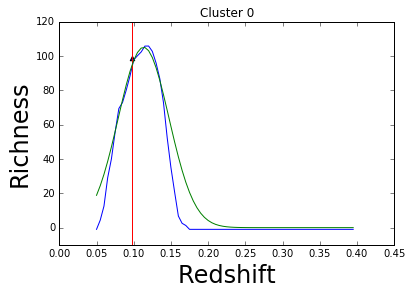

In [ ]:
def make_plot(z_peak, sigmaz, lambda_peak, z_true, lambda_true, z_domain, lambda_array, save=False, index=None):
    plt.plot(z_domain, lambda_array)
    plt.scatter(z_true, lambda_true, marker='^')
    plt.axvline(z_true, c='r')
    plt.plot(z_domain, lambda_model(z_domain, sigmaz, z_peak, lambda_peak))
    plt.ylabel("Richness", fontsize=24)
    plt.xlabel("Redshift", fontsize=24)
    if index is not None:
        plt.title("Cluster %d"%index)
    plt.ylim(-10, max(plt.gca().get_ylim()))
    return

make_plot(zbest, szbest, lambest, z_true[0], lambda_true[0], z_domain, lambda_arrays[0], index=0)

Great. Let's proceed with every other cluster and save the outputs.

In [ ]:
N = len(lambda_arrays)
sz_all = np.zeros((N)) #sigmaz for all clusters
zp_all = np.zeros((N)) #z_peak for all clusters
lp_all = np.zeros((N)) #lambda_peak for all clusters
for i in xrange(0,N):
    x0 = [z_true[i], 0.03, lambda_true[i]]
    result = minimize(comparison, x0=x0, args=(z_domain, lambda_arrays[i]), method='Nelder-Mead')
    zp_all[i], sz_all[i], lp_all[i] = result['x']
    if i%500==0: print "At cluster %d"%i
outpath = "output_files/"
dataset = 'dr8_0.4_'
np.savetxt(outpath+dataset+"zpeak.txt",zp_all)
np.savetxt(outpath+dataset+"sigmaz.txt",sz_all)
np.savetxt(outpath+dataset+"lambdapeak.txt",lp_all)
print "Saved successfully."

At cluster 0
At cluster 500
At cluster 1000
At cluster 1500


/home/tmcclintock/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in divide
/home/tmcclintock/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in divide


At cluster 2000
At cluster 2500
At cluster 3000
At cluster 3500
At cluster 4000
At cluster 4500


/home/tmcclintock/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:528: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


At cluster 5000
At cluster 5500


Make the scatter plot of the resulting $\sigma_z(z)$ points.

In [ ]:
#First split by richnesses
colors = ['g','r','b']
edges = [20, 30, 60, 9999]
for i in range(len(edges) - 1):
    lo = edges[i]
    hi = edges[i+1]
    indices = (lambda_true >= lo) * (lambda_true < hi)
    plt.scatter(z_true[indices], sz_all[indices], c=colors[i], label=r'$\lambda\in(%d,%d)$'%(lo,hi), alpha=0.2)
plt.xlabel('Redshift', fontsize=24)
plt.ylabel(r'$\sigma_z$', fontsize=24)
plt.legend(loc='upper left')
plt.ylim(0,.2)

Looks like there is a trend, but it is difficult to tell without inspecting everything individually whether there are significant outliers.